In [1]:
import cupy as xp
from numpy.ma import masked_array
import matplotlib.pyplot as plt

from arte.types.mask import CircularMask
from arte.math.toccd import toccd

from ekarus.e2e.devices.pyr3_wfs import Pyr3WFS
from ekarus.e2e.devices.detector import Detector
from ekarus.e2e.devices.slope_computer import SlopeComputer
# from ekarus.e2e.utils.zernike_coefficients import create_field_from_zernike_coefficients

from  ekarus.e2e.utils.image_utils import get_photocenter, image_grid


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
from arte.utils.zernike_generator import ZernikeGenerator

def create_field_from_zernike_coefficients(mask, noll_ids:tuple, amplitudes:tuple):
    """
    Create an electric field input corresponding to a Zernike aberration.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: input electric field as a numpy complex array
    """
    phase = project_zernike_on_mask(mask, noll_ids, amplitudes)
    amp = xp.asarray(mask.asTransmissionValue())
    return  amp * xp.exp(1j * phase)


def project_zernike_on_mask(mask, noll_ids:tuple, amplitudes:tuple):
    """
    Create a linear combination of Zernikes on a mask.
    
    :param mask: CircularMask object defining the pupil
    :param noll_ids: tuple of Zernike noll number
    :param amplitudes: Amplitude or tuple of amplitudes
                       of the Zernike aberration in radians
    
    :return: zernike combination
    """
    zg = ZernikeGenerator(mask)

    if isinstance(noll_ids,int):
        amp = amplitudes
        noll = noll_ids
        zern = amp * xp.asarray(zg.getZernike(noll))
    else:
        amplitudes *= xp.ones(len(noll_ids))
        zern = xp.zeros(mask.mask().shape)
        for amp,noll in zip(amplitudes, noll_ids):
            zern += amp * xp.asarray(zg.getZernike(noll))

    return zern

In [3]:
def imageShow(image2d, pixelSize=1, title='', xlabel='', ylabel='', zlabel='', shrink=1.0):
    sz=image2d.shape
    plt.imshow(image2d, extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                                -sz[1]/2*pixelSize, sz[1]/2*pixelSize])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar(shrink=shrink)
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= xp.asnumpy(xp.log(image[roi[0]: roi[1], roi[0]:roi[1]]))
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

rad2arcsec = 180/xp.pi*3600
def compute_pixel_size(wavelength, pupil_diameter_in_m, padding=1):
    return wavelength/pupil_diameter_in_m*rad2arcsec/padding

def tilt_field(pyr, field, tiltAmpX, tiltAmpY):
    tiltX,tiltY = pyr._get_XY_tilt_planes(field.shape)
    wedge_tilt = (tiltX*tiltAmpX + tiltY*tiltAmpY)*(2*xp.pi)#*pyr.oversampling
    focal_plane_field = xp.fft.fftshift(xp.fft.fft2(field))
    field = focal_plane_field * xp.exp(1j*wedge_tilt)#, dtype=pyr.cdtype)
    field = xp.fft.ifft2(xp.fft.ifftshift(field))
    return field

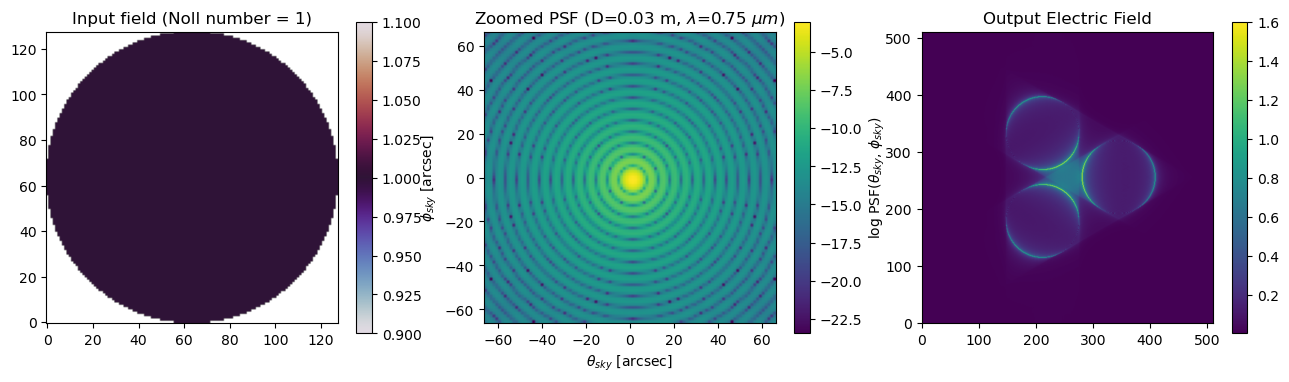

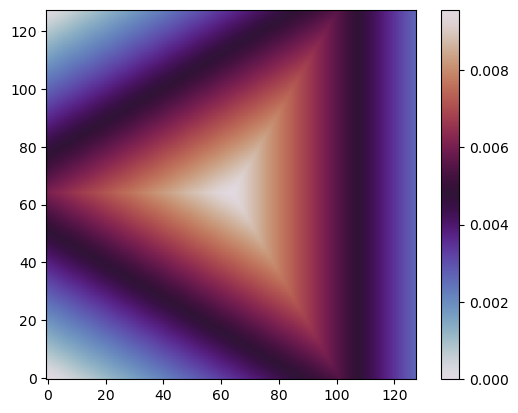

In [4]:
Npix = 128

# Create pupil mask
oversampling = 4
mask = CircularMask((Npix,Npix), maskRadius=Npix // 2)

# Conversions
pupilDiameterInM = 30e-3
lambdaInM = 750e-9
pix2arcsec = compute_pixel_size(wavelength=lambdaInM, pupil_diameter_in_m=pupilDiameterInM, padding = oversampling)
pix2rad = pix2arcsec/rad2arcsec
lambdaOverD = lambdaInM/pupilDiameterInM

# Create the input electric field for flat wavefront (a piston of 1 radians)
noll = 1
zern_amp = 1
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)

# Pyramid WFS
apex_angle = (Npix+30)/(3*xp.cos(xp.pi/6))*(2*xp.pi)*lambdaOverD
wfs = Pyr3WFS(apex_angle, oversampling, sensorLambda=lambdaInM)

# Electric field propagation
padded_field = xp.pad(input_field, int((oversampling-1)/2*Npix), mode='constant', constant_values=0.0)
output_field = wfs.propagate(padded_field, lambdaOverD)
intensity = xp.abs(output_field**2)

# Compute normalized psf
psf = xp.abs(xp.abs(wfs.field_on_focal_plane**2))
psf *= 1/xp.sum(psf)

# Plotting results
s = 0.45
plt.figure(1, figsize=(16,9))
plt.subplot(1, 3, 1)
plt.title(f'Input field (Noll number = {noll})')
plt.imshow(masked_array(xp.asnumpy(xp.angle(input_field)),mask=1-xp.asnumpy(xp.abs(input_field))), cmap='twilight', origin='lower')
plt.colorbar(shrink=s)

plt.subplot(1, 3, 2)
showZoomCenter(psf, pix2arcsec, title=r'Zoomed PSF (D=%g m, $\lambda$=%g $\mu m$)' % (pupilDiameterInM, lambdaInM*1e6),
               xlabel=r'$\theta_{sky}$ [arcsec]', ylabel=r'$\phi_{sky}$ [arcsec]',
               zlabel=r'log PSF($\theta_{sky}$, $\phi_{sky}$)', shrink=0.45)


plt.subplot(1, 3, 3)
plt.title("Output Electric Field")
plt.imshow(xp.asnumpy(intensity),origin='lower')
plt.colorbar(shrink=s)
plt.show()

plt.figure()
plt.imshow(xp.asnumpy(wfs.pyr3_phase_delay((Npix,Npix))),origin='lower',cmap='twilight')
plt.colorbar()

In [5]:
padded_field = xp.pad(xp.asarray(mask.asTransmissionValue()), int((oversampling-1)/2*Npix), mode='constant', constant_values=0.0)
wfs.set_modulation_angle(modulationAngleInLambdaOverD=20)
modulated_intensity = wfs.modulate(padded_field, lambdaOverD)

Modulating 20 [lambda/D] with 140 modulation steps


84510 84657 92977


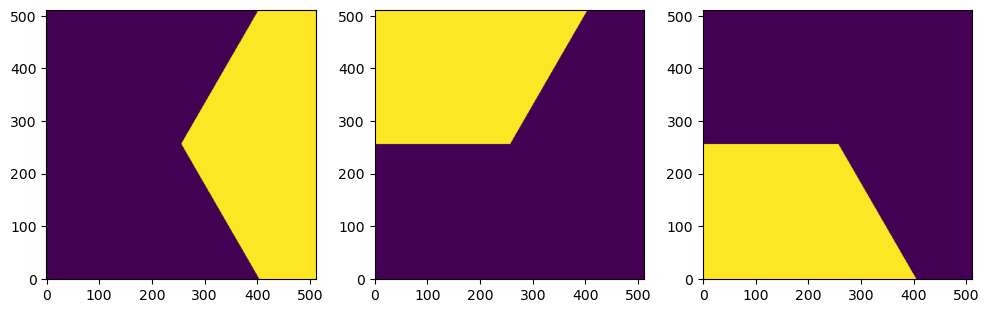

In [6]:
X,Y = image_grid(modulated_intensity.shape,recenter=True)
tri_right = X>abs(Y)/xp.tan(xp.pi/3)
tri_uleft = xp.logical_and(Y>=0,X<=abs(Y)/xp.tan(xp.pi/3))
tri_bleft = xp.logical_and(Y<0,X<=abs(Y)/xp.tan(xp.pi/3))

plt.figure(figsize=(12,3.5))
plt.subplot(1,3,1)
plt.imshow(xp.asnumpy(tri_right),origin='lower')
plt.subplot(1,3,2)
plt.imshow(xp.asnumpy(tri_uleft),origin='lower')
plt.subplot(1,3,3)
plt.imshow(xp.asnumpy(tri_bleft),origin='lower')

print(xp.sum(tri_uleft),xp.sum(tri_bleft),xp.sum(tri_right))

344.31555 255.50203 88.316956
211.09059 332.49072 88.699974
211.09431 178.51155 89.55993


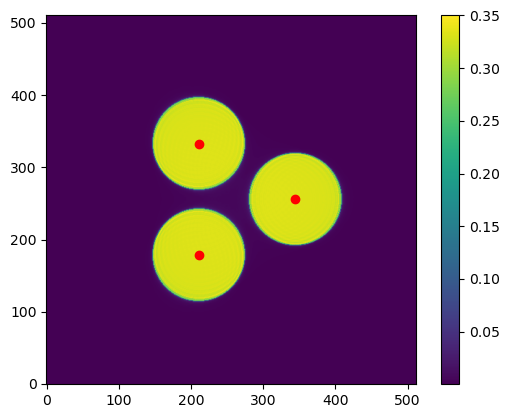

In [7]:
plt.figure()
plt.imshow(xp.asnumpy(modulated_intensity),origin='lower')
plt.colorbar()

cx = (Npix*oversampling)//2
cy = (Npix*oversampling)//2

rr = lambda qx, qy: xp.sqrt((qx-cx)**2+(qy-cy)**2)

ul_intensity = modulated_intensity*tri_right
qx,qy = get_photocenter(ul_intensity)
plt.scatter(xp.asnumpy(qx),xp.asnumpy(qy),c='red')
print(qx,qy,rr(qx,qy))
ul_intensity = modulated_intensity*tri_uleft
qx,qy = get_photocenter(ul_intensity)
plt.scatter(xp.asnumpy(qx),xp.asnumpy(qy),c='red')
print(qx,qy,rr(qx,qy))
ul_intensity = modulated_intensity*tri_bleft
qx,qy = get_photocenter(ul_intensity)
plt.scatter(xp.asnumpy(qx),xp.asnumpy(qy),c='red')
print(qx,qy,rr(qx,qy))

In [8]:
L = 2*rr(qx,qy)*xp.cos(xp.pi/6)
print(L,L-Npix,L/2)

155.12234716673836 27.122347166738365 77.56117358336918


In [9]:
detector_shape = (256,256)#(64,64)
ccd = Detector(detector_shape=detector_shape)

3PWFS
Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps


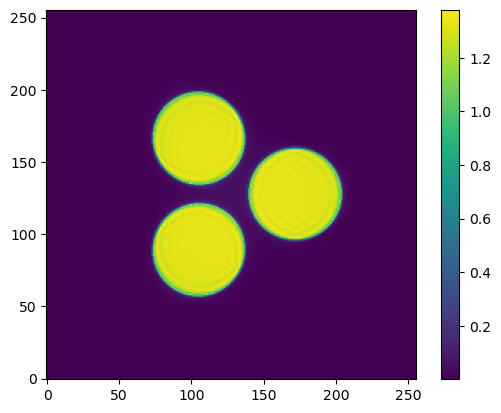

In [10]:
pars = {'modulationInLambdaOverD':3, 'slope_method': 'raw_intensity'}

sc = SlopeComputer(wfs, ccd, pars)
print(sc.wfs_type)
sc.calibrate_sensor(tn='', prefix_str='', recompute=True, zero_phase=xp.asarray(mask.asTransmissionValue()), lambdaOverD=lambdaOverD, Npix=64, centerObscurationInPixels=0.0)
subapertures = sc._roi_masks

ccd_modulated_intensity = ccd.last_frame #toccd(modulated_intensity,ccd.detector_shape)

plt.figure()
plt.imshow(xp.asnumpy(ccd_modulated_intensity), origin='lower')
plt.colorbar()

Modulating 3 [lambda/D] with 20 modulation steps
3


Text(0.5, 1.0, 'Masked Intensity C')

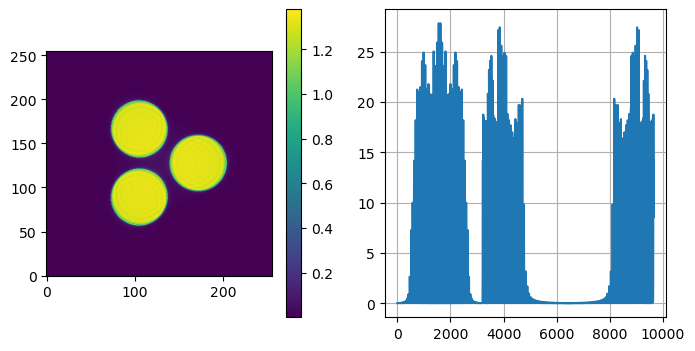

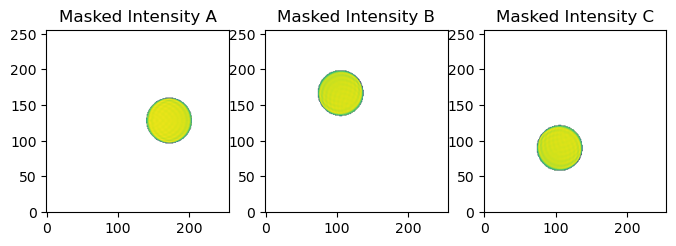

In [11]:
wfs.set_modulation_angle(modulationAngleInLambdaOverD=3)
print(wfs.modulationAngleInLambdaOverD)
# method='all_slopes'
slope = sc.compute_slopes(ccd_modulated_intensity, lambdaOverD, nPhotons=None)
# sc._slope_method = method

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(ccd_modulated_intensity), origin='lower')
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(xp.asnumpy(slope))
plt.grid()

plt.figure(figsize=(8,8))
plt.subplot(1,3, 1)
plt.imshow(masked_array(xp.asnumpy(ccd_modulated_intensity), mask=xp.asnumpy(subapertures[0])), origin='lower')
plt.title("Masked Intensity A")
plt.subplot(1,3, 2)
plt.imshow(masked_array(xp.asnumpy(ccd_modulated_intensity), mask=xp.asnumpy(subapertures[1])), origin='lower')
plt.title("Masked Intensity B")
plt.subplot(1,3, 3)
plt.imshow(masked_array(xp.asnumpy(ccd_modulated_intensity), mask=xp.asnumpy(subapertures[2])), origin='lower')
plt.title("Masked Intensity C")

Modulating 3 [lambda/D] with 20 modulation steps


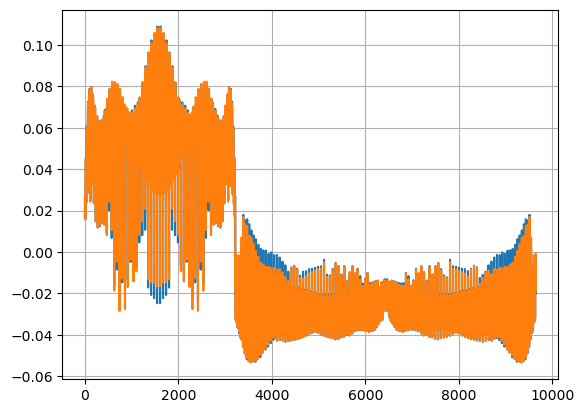

In [12]:
wfs.set_modulation_angle(3)
# method = 'slopes'

noll = 2
amp = 0.1
null_sig = create_field_from_zernike_coefficients(mask, noll, amp*0)
tilt_up = create_field_from_zernike_coefficients(mask, noll, amp)
tilt_down = create_field_from_zernike_coefficients(mask, noll, -amp)

# sc._slope_method = method
null_slope = sc.compute_slopes(null_sig, lambdaOverD, nPhotons=None)
up_slopes = sc.compute_slopes(tilt_up, lambdaOverD, nPhotons=None)
down_slopes = sc.compute_slopes(tilt_down, lambdaOverD, nPhotons=None)

plt.figure()
plt.plot(xp.asnumpy(up_slopes-null_slope))
plt.plot(xp.asnumpy(-(down_slopes-null_slope)))
plt.grid()

In [13]:
# Compute slopes for Zernike modes
N = 9
Nmodes = (N-1)*(N-2)//2
IM = xp.zeros((int(xp.size(slope)),Nmodes))

zern_amp = 0.02
N0 = 2

for i in range(Nmodes):

    noll = N0 + i
    input_zern = create_field_from_zernike_coefficients(mask, noll, zern_amp)
    zern_slopes = sc.compute_slopes(input_zern, lambdaOverD, nPhotons=None)

    IM[:,i] = zern_slopes/zern_amp

U,S,V = xp.linalg.svd(IM, full_matrices=False)

Sinv = 1/S
Rec = (V.T * Sinv) @ U.T

Text(0.5, 1.0, 'Measured intensity')

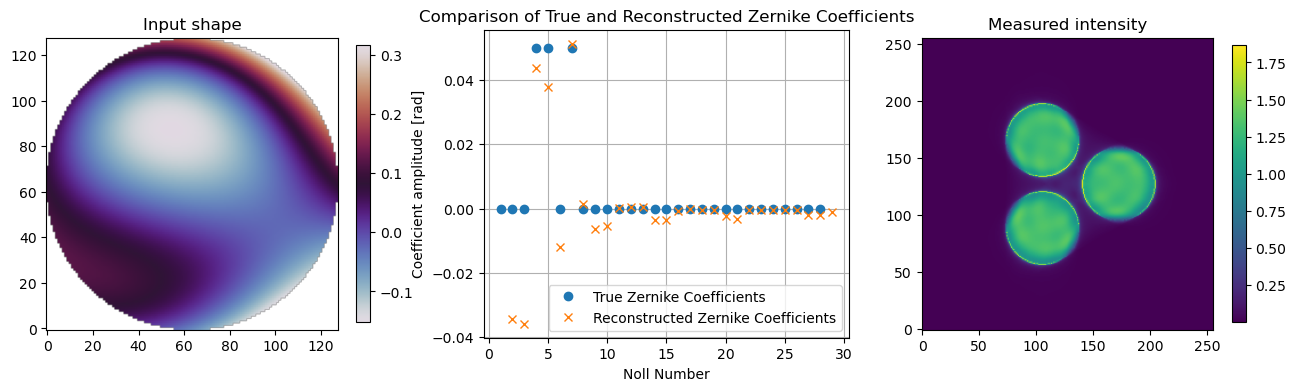

In [14]:
# Test the reconstructor
zids = (4,5,7)
zamps = 0.05
zern_mix = create_field_from_zernike_coefficients(mask, zids, zamps)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(masked_array(xp.asnumpy(xp.angle(zern_mix)),mask=mask.mask()), cmap='twilight',origin='lower')
plt.colorbar(shrink=0.9)
plt.title('Input shape')

# Propagate the field through the WFS
# output_field = wfs.propagate(zern_mix/pix2rad)
# output_intensity = xp.abs(output_field**2)

# Compute slopes
slopes = sc.compute_slopes(zern_mix, lambdaOverD, nPhotons=None)
output_intensity = ccd.last_frame

# Reconstruct the Zernike coefficients
zern_reconstructed = Rec @ slopes
rec_noll_ids = xp.arange(Nmodes)+N0

noll_ids = xp.arange(Nmodes)+1
true_zern = xp.zeros(Nmodes)
true_zern[xp.array(zids)-1] = zamps

plt.subplot(1,3,2)
plt.plot(xp.asnumpy(noll_ids), xp.asnumpy(true_zern), 'o', label='True Zernike Coefficients')
plt.plot(xp.asnumpy(rec_noll_ids), xp.asnumpy(zern_reconstructed), 'x', label='Reconstructed Zernike Coefficients')
plt.xlabel('Noll Number')
plt.ylabel('Coefficient amplitude [rad]')
plt.title('Comparison of True and Reconstructed Zernike Coefficients')
plt.legend(loc='best')
plt.grid()

ccd_intensity = toccd(output_intensity, ccd.detector_shape)

plt.subplot(1,3,3)
plt.imshow(xp.asnumpy(ccd_intensity),origin='lower')
plt.colorbar(shrink=0.9)
plt.title('Measured intensity')

In [15]:
def push_pull_calibrate(Nmodes, method:str='slopes', amp:float = 0.02):
    
    slope_len = int(xp.sum(1-sc._roi_masks))
    IM = xp.zeros((slope_len,Nmodes))
    nx = 129
    mask = CircularMask((nx,nx), maskRadius=nx // 2)
    sc._slope_method = method

    for i in range(Nmodes):

        noll = 2 + i

        input_zern = create_field_from_zernike_coefficients(mask, noll, amp)
        push_slope = sc.compute_slopes(input_zern, lambdaOverD, nPhotons=None)/amp
        pull_slope = sc.compute_slopes(xp.conj(input_zern), lambdaOverD, nPhotons=None)/amp

        if noll <= 16:
            plt.figure(figsize=(18,5))
            plt.subplot(1,3,1)
            plt.plot(xp.asnumpy(push_slope))
            plt.grid()
            plt.subplot(1,3,2)
            plt.plot(xp.asnumpy(pull_slope))
            plt.title(f'Noll {noll}')
            plt.grid()
            plt.subplot(1,3,3)
            plt.plot(xp.asnumpy((push_slope-pull_slope)/2))
            plt.grid()

        IM[:,i] = (push_slope-pull_slope)/2

    Rec = xp.linalg.pinv(IM)

    return Rec, IM

Modulating 3 [lambda/D] with 20 modulation steps


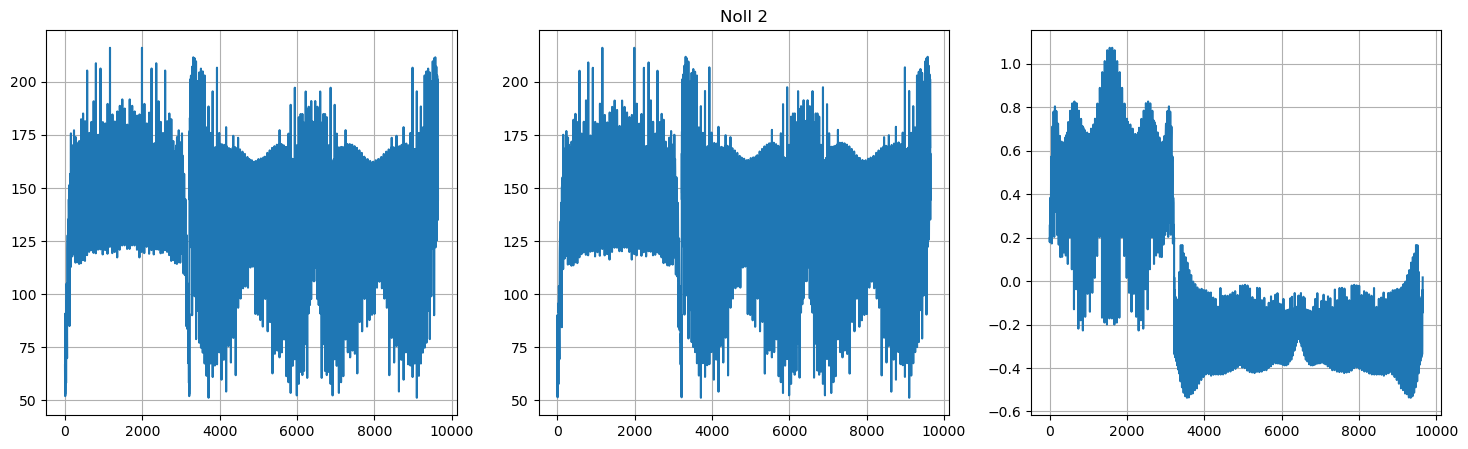

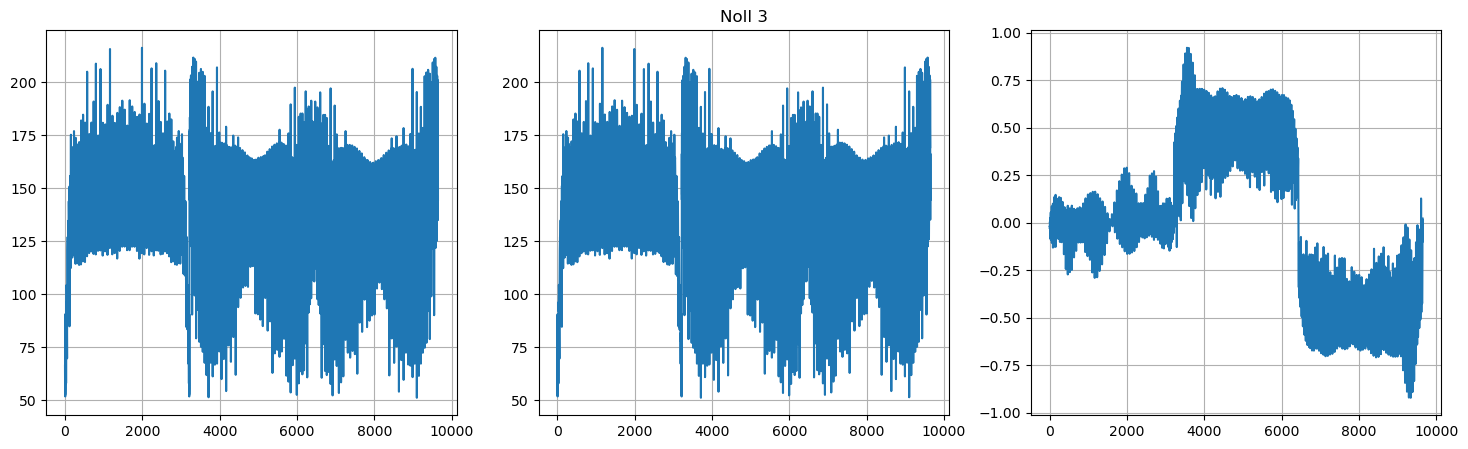

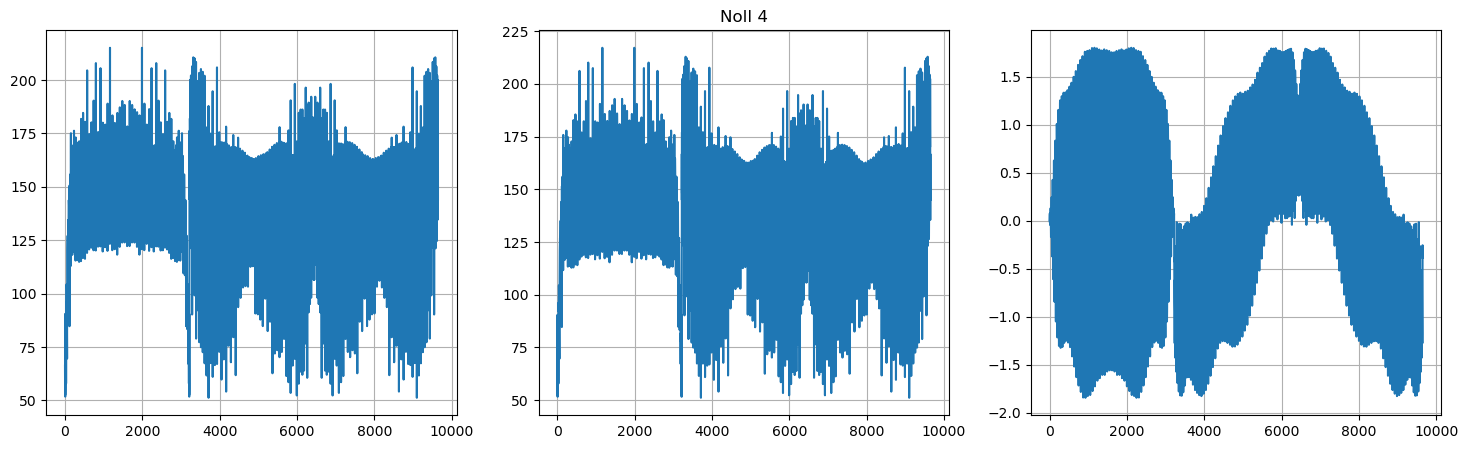

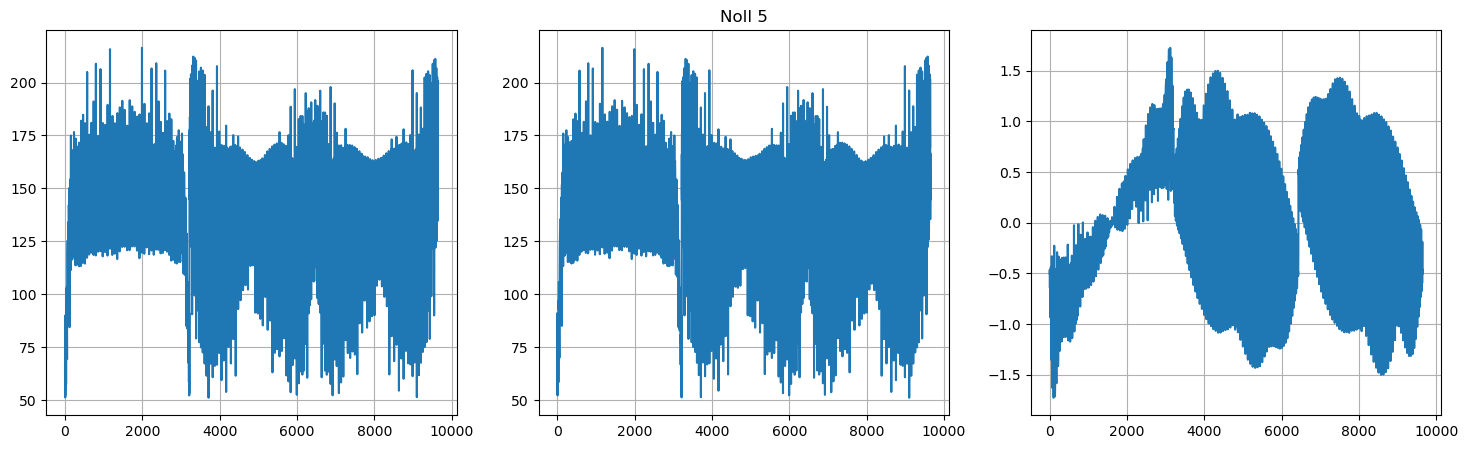

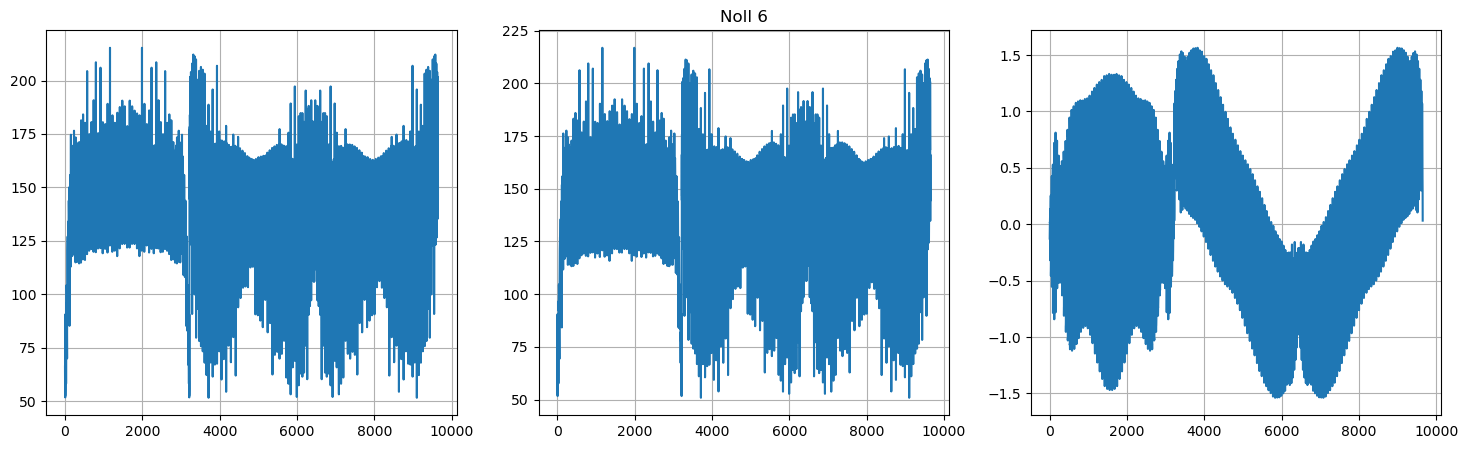

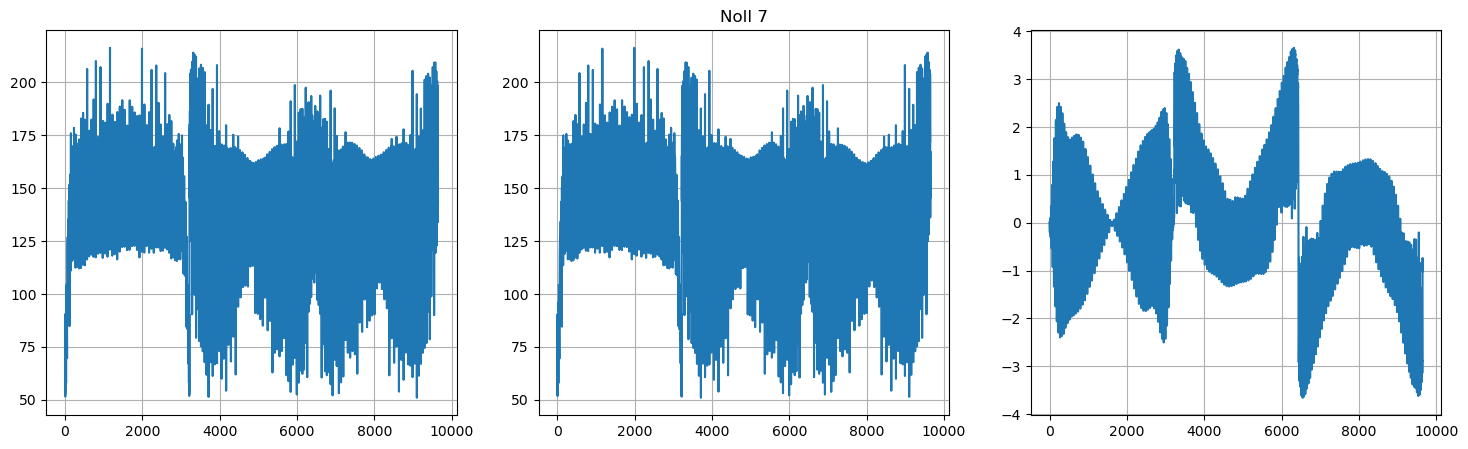

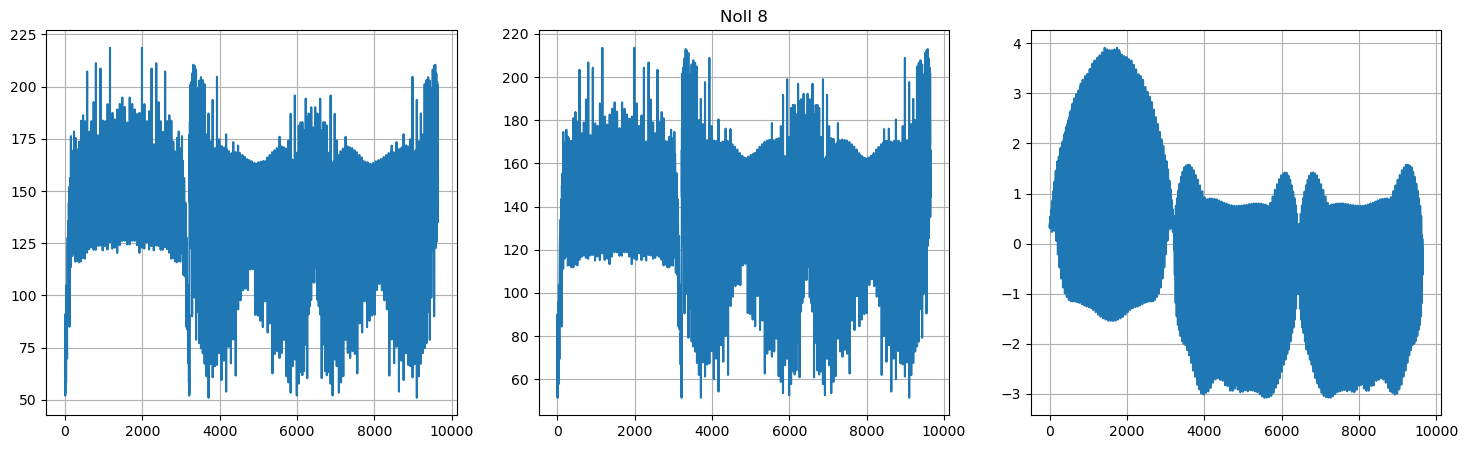

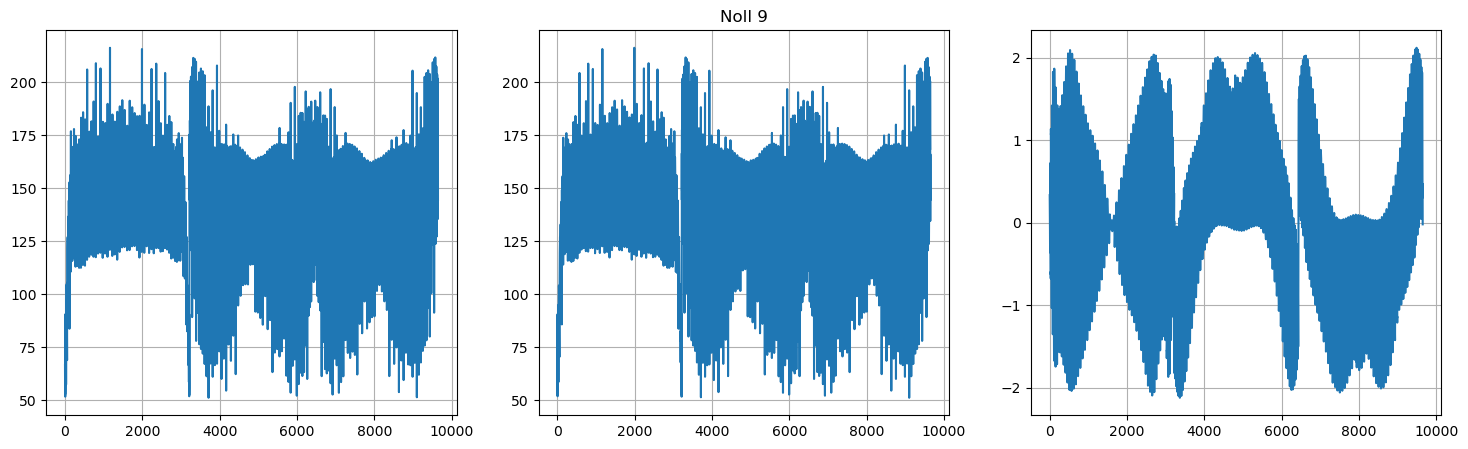

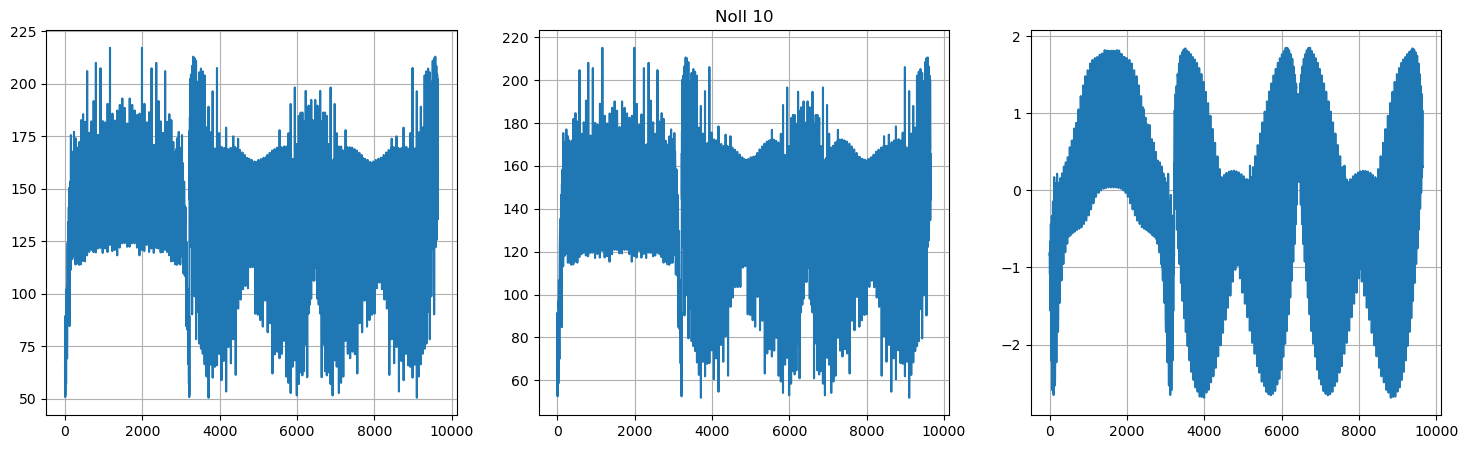

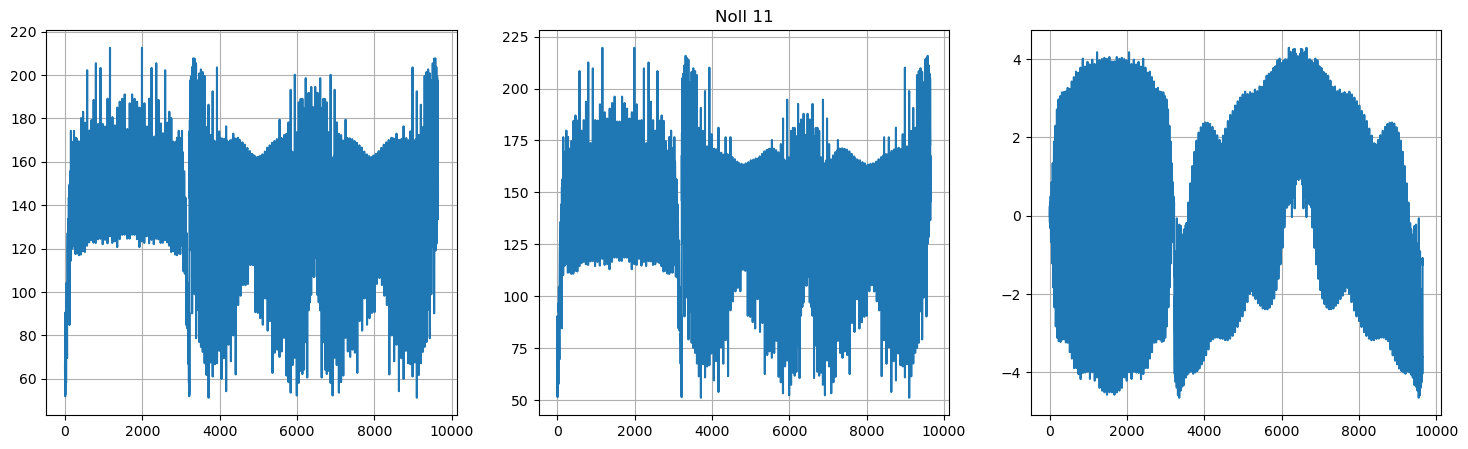

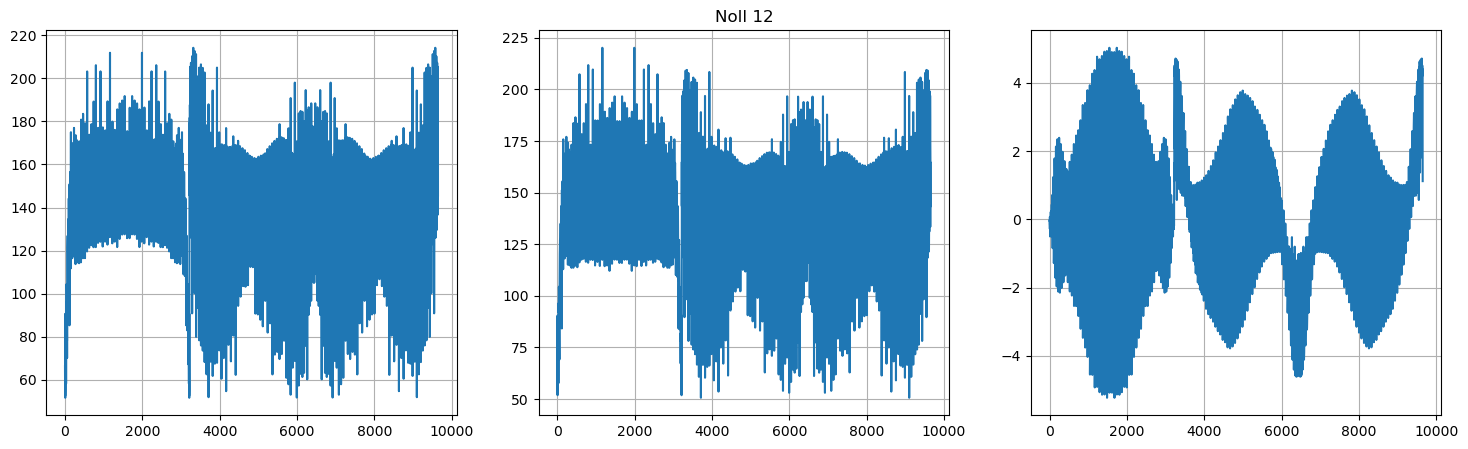

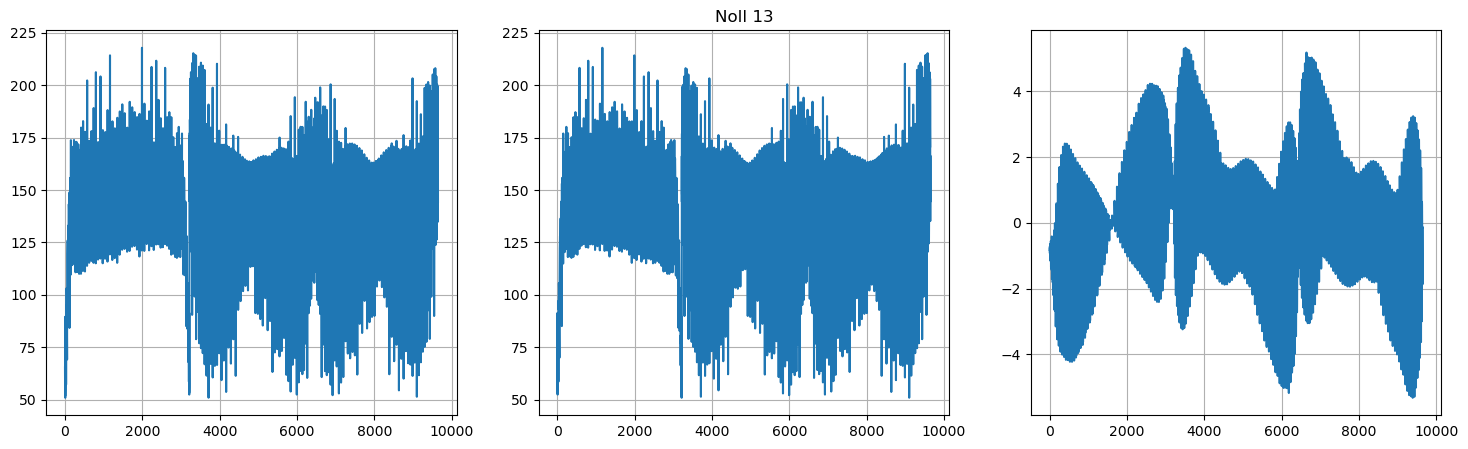

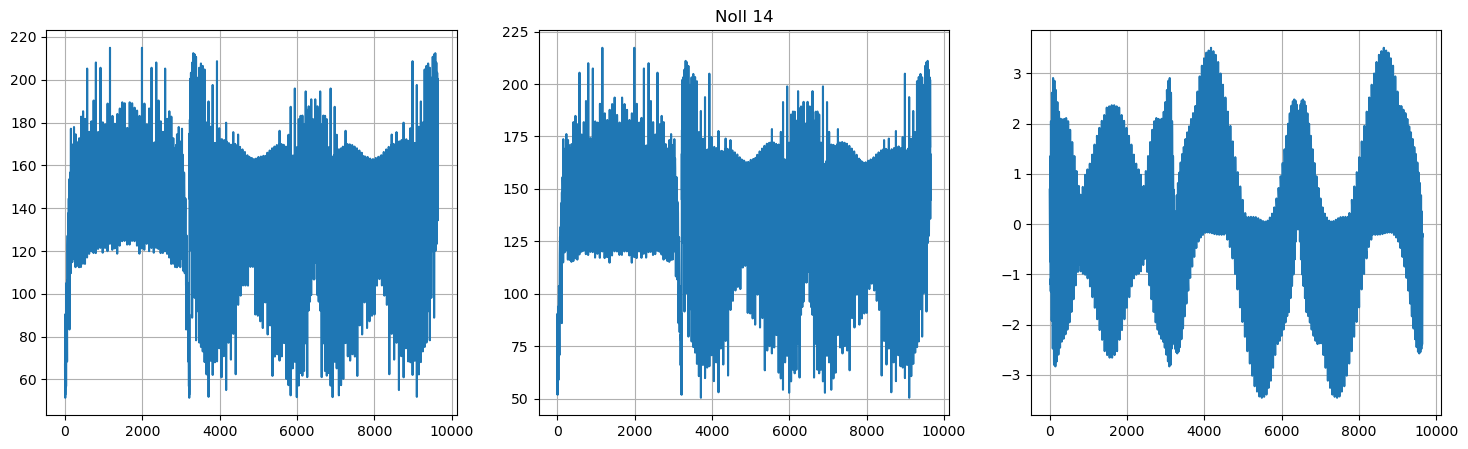

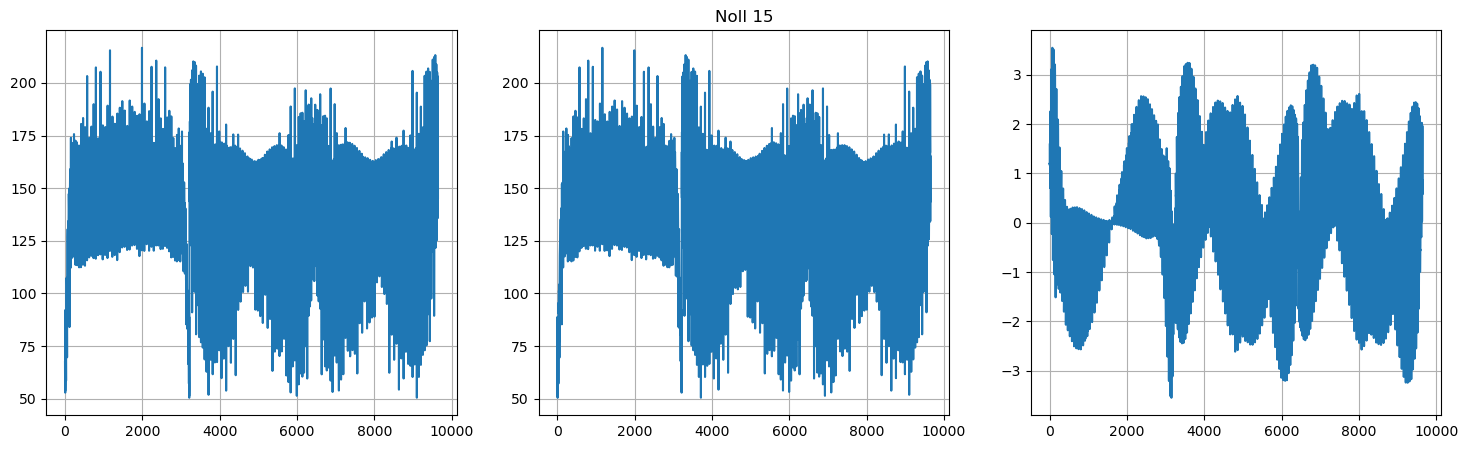

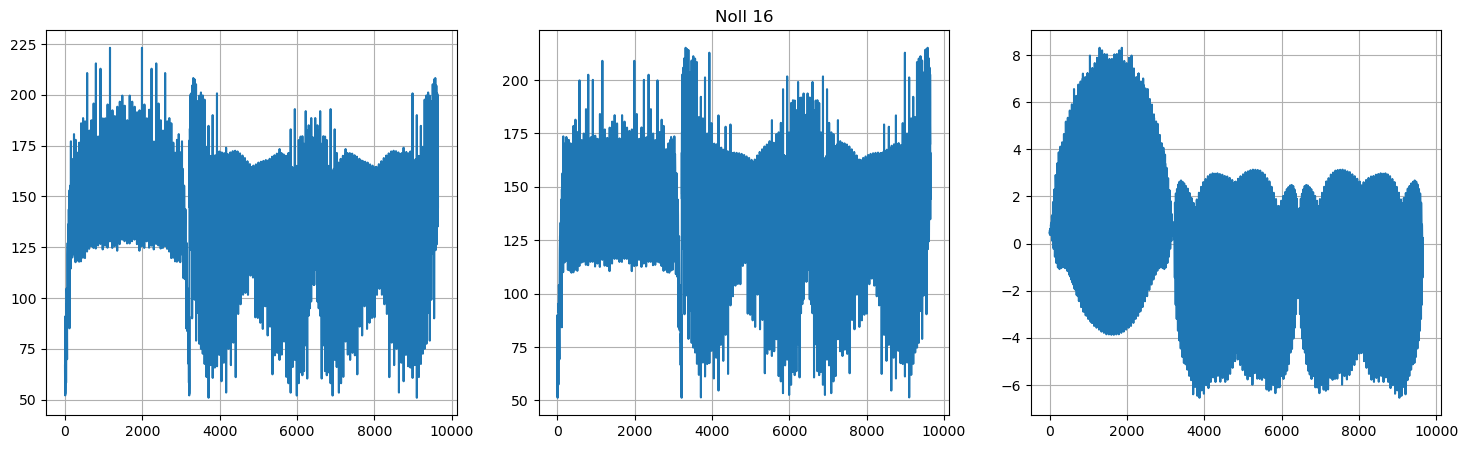

In [16]:
N = 6
nRecModes = int((N+1)*N/2)

# method='slopes'
# method='all_slopes'
method='raw_intensity'

wfs.set_modulation_angle(3)
RecPP,IMpp = push_pull_calibrate(nRecModes, method=method)

Modulating 3 [lambda/D] with 20 modulation steps
3.0


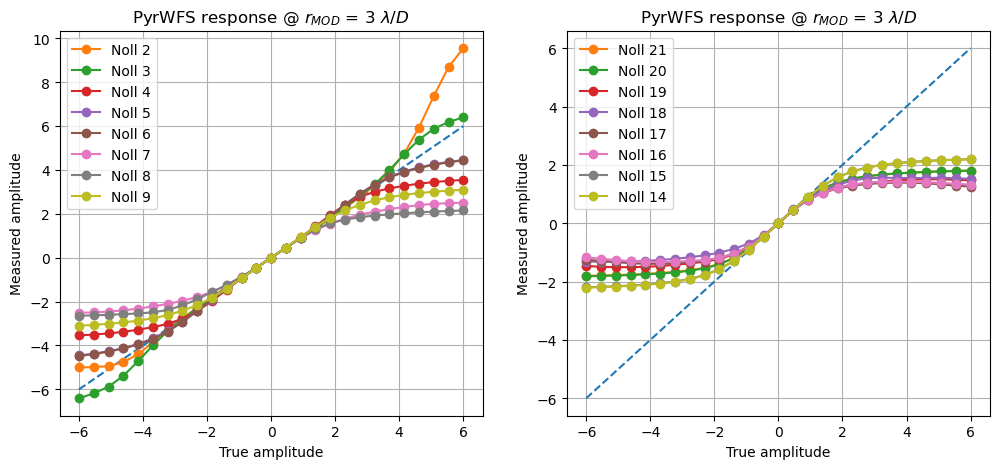

In [17]:
# Linearity check
Nmodes = 8
wfs.set_modulation_angle(3.0)
print(wfs.modulationAngleInLambdaOverD)
amp_vec = xp.linspace(-6,6,27,endpoint=True)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(amp_vec),xp.asnumpy(amp_vec),'--')
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(amp_vec),xp.asnumpy(amp_vec),'--')

intensities = xp.zeros((Nmodes,xp.shape(output_intensity)[0],xp.shape(output_intensity)[1]))
rev_intensities = xp.zeros((Nmodes,xp.shape(output_intensity)[0],xp.shape(output_intensity)[1]))

for j in range(Nmodes):

    zid = j + 2
    meas_amp = xp.zeros_like(amp_vec)

    rev_zid = nRecModes - j
    rev_meas_amp = xp.zeros_like(amp_vec)

    zero = create_field_from_zernike_coefficients(mask, 1, 0)
    slope_null = sc.compute_slopes(zero, lambdaOverD, nPhotons=None)

    for k,amp in enumerate(amp_vec):
        zern = create_field_from_zernike_coefficients(mask, zid, amp)
        slopes = sc.compute_slopes(zern, lambdaOverD, nPhotons=None)
        slopes -= slope_null
        output_intensity = ccd.last_frame
        zern_reconstructed = RecPP @ slopes
        meas_amp[k] = zern_reconstructed[zid-2]

        rev_zern = create_field_from_zernike_coefficients(mask, rev_zid, amp_vec[k])
        slopes = sc.compute_slopes(rev_zern, lambdaOverD, nPhotons=None)
        slopes -= slope_null
        rev_output_intensity = ccd.last_frame
        zern_reconstructed = RecPP @ slopes
        rev_meas_amp[k] = zern_reconstructed[rev_zid-2]
    
    intensities[j,:,:] = output_intensity
    rev_intensities[j,:,:] = rev_output_intensity

    plt.subplot(1,2,1)
    plt.plot(xp.asnumpy(amp_vec), xp.asnumpy(meas_amp),'-o', label=f'Noll {zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 3 $\lambda/D$')
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(xp.asnumpy(amp_vec), xp.asnumpy(rev_meas_amp),'-o', label=f'Noll {rev_zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 3 $\lambda/D$')
    plt.grid(True)

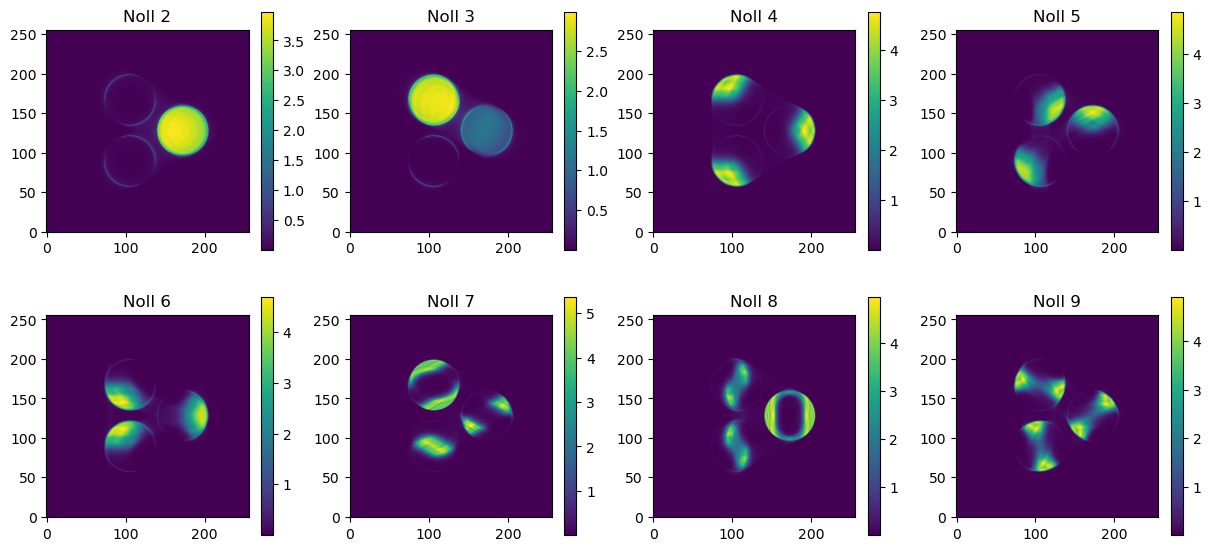

In [18]:
# Plot the intensity on the detector for the last iteration
n_rows = Nmodes//4+1
plt.figure(figsize=(15,3.5*n_rows))

for i in range(Nmodes):
    plt.subplot(n_rows,4,i+1)

    # plt.imshow((intensities[i,:,:]),origin='lower')
    plt.imshow(xp.asnumpy(toccd(intensities[i,:,:],ccd.detector_shape)),origin='lower')
    plt.colorbar()
    plt.title(f'Noll {i+2}')

Modulating 0 [lambda/D] with 0 modulation steps


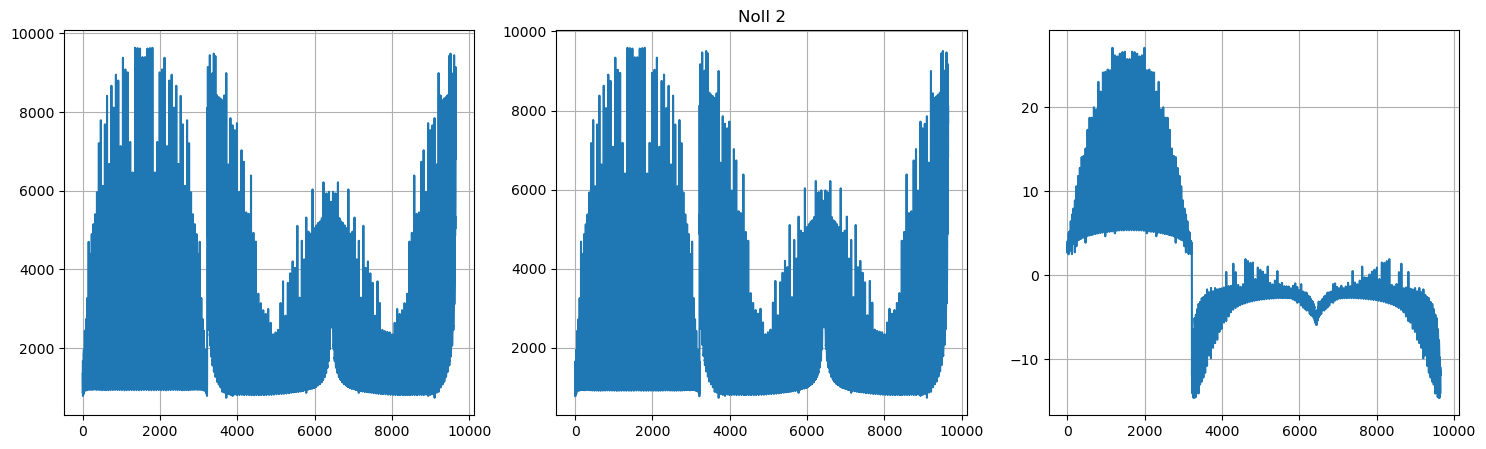

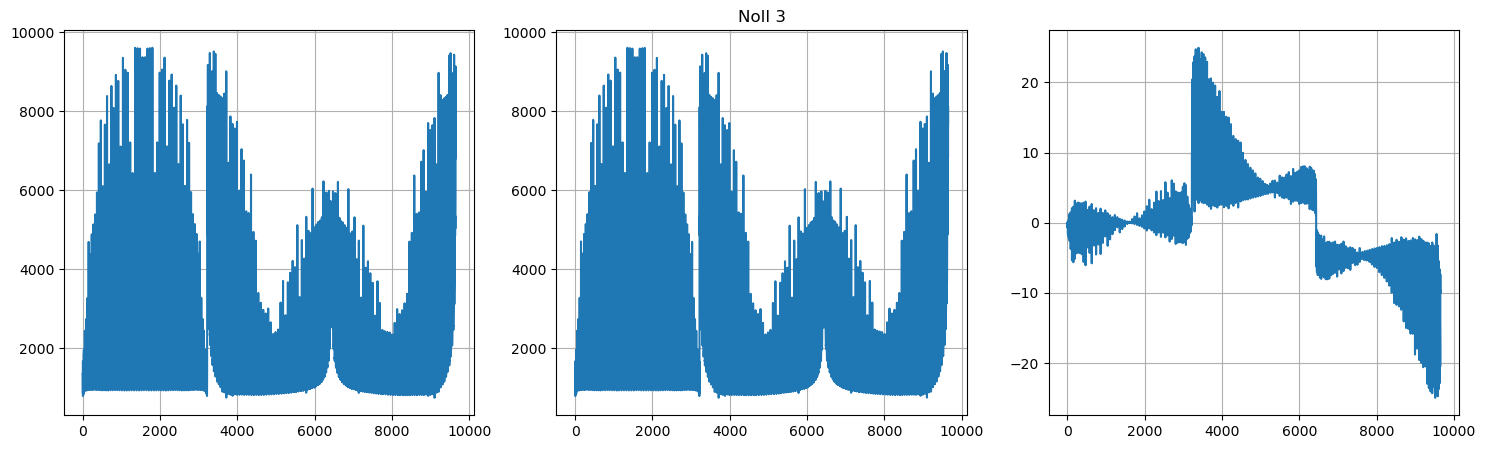

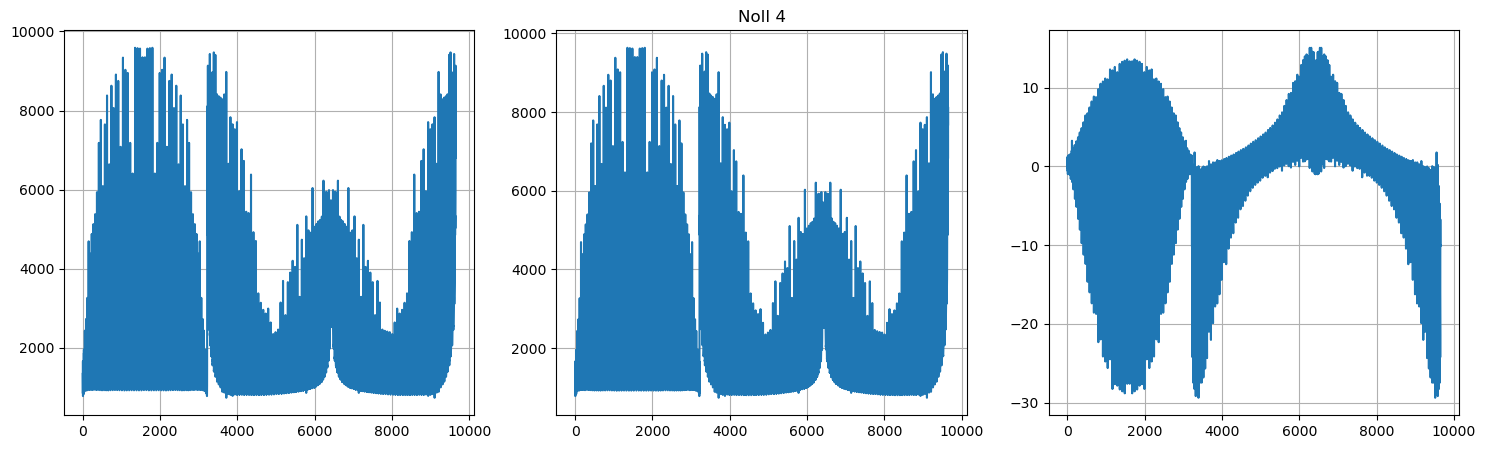

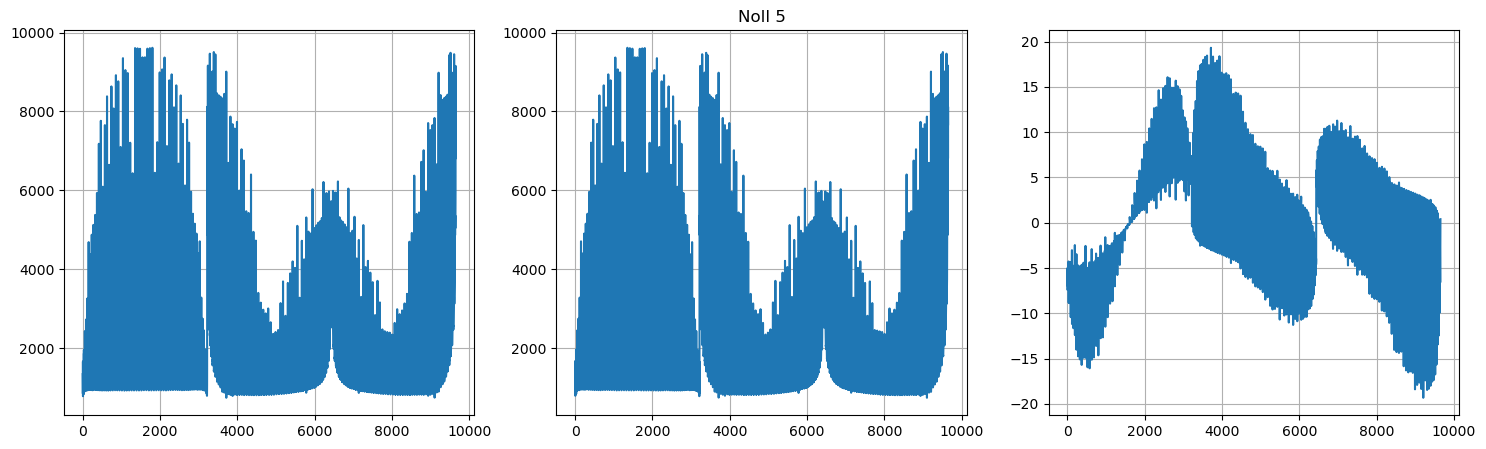

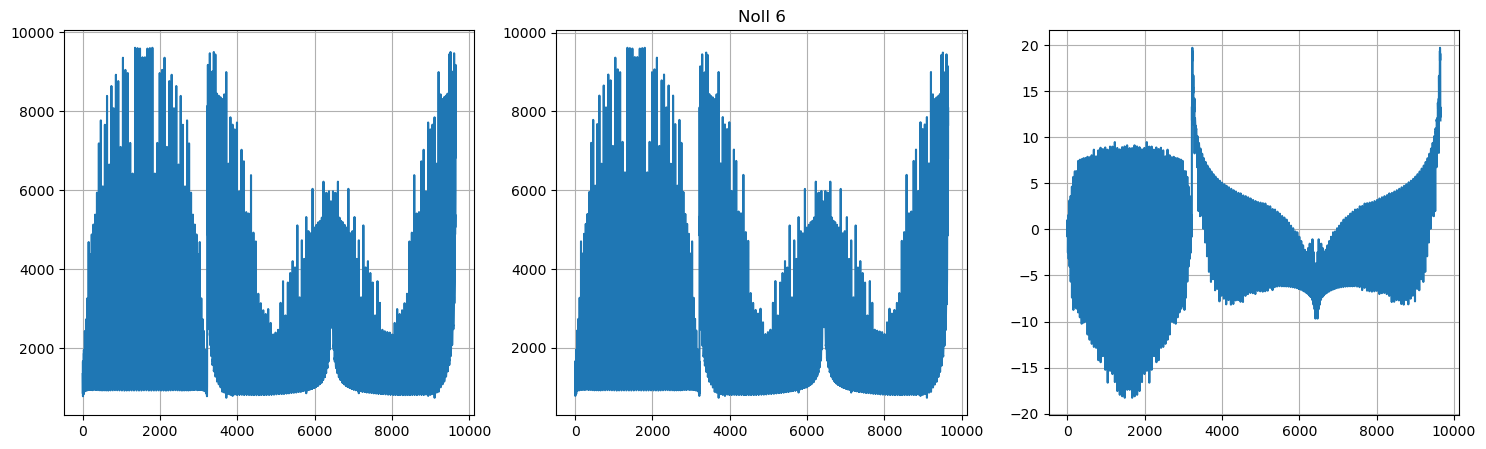

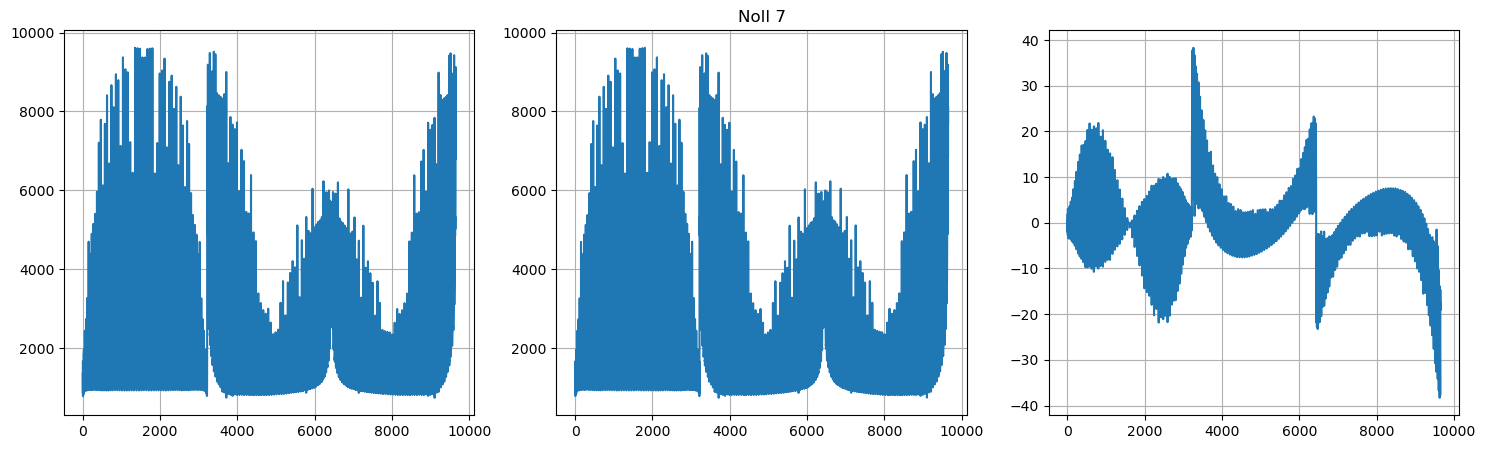

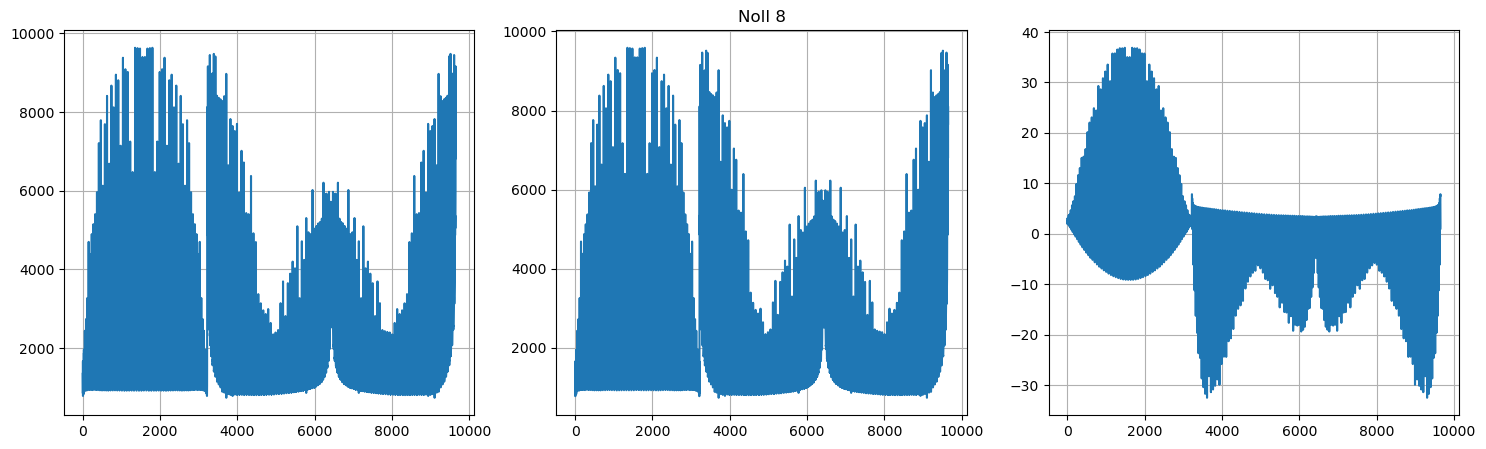

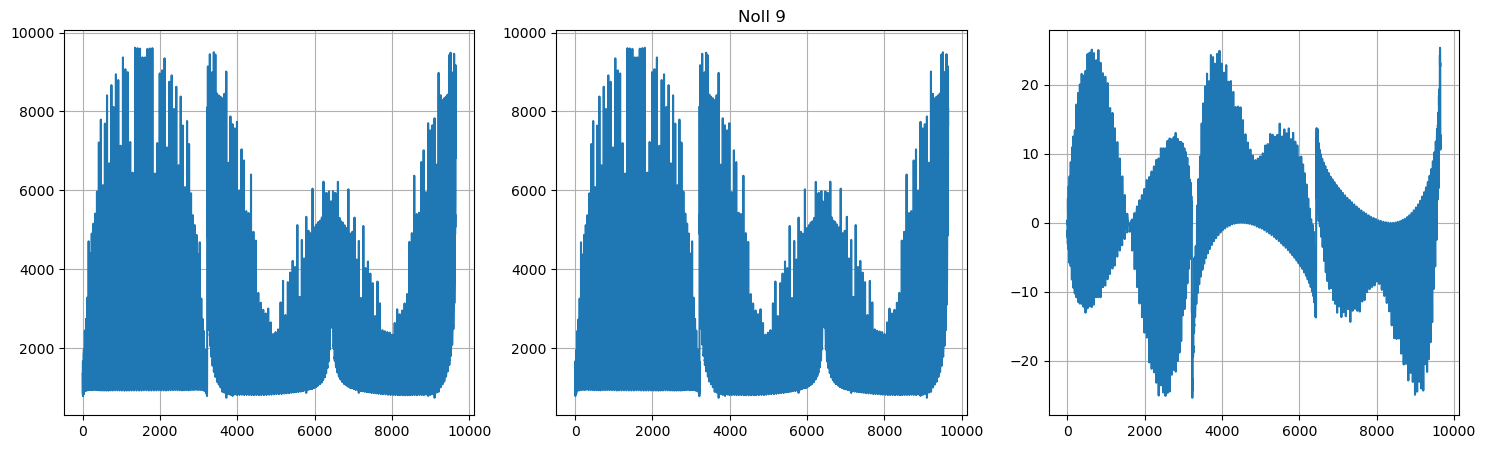

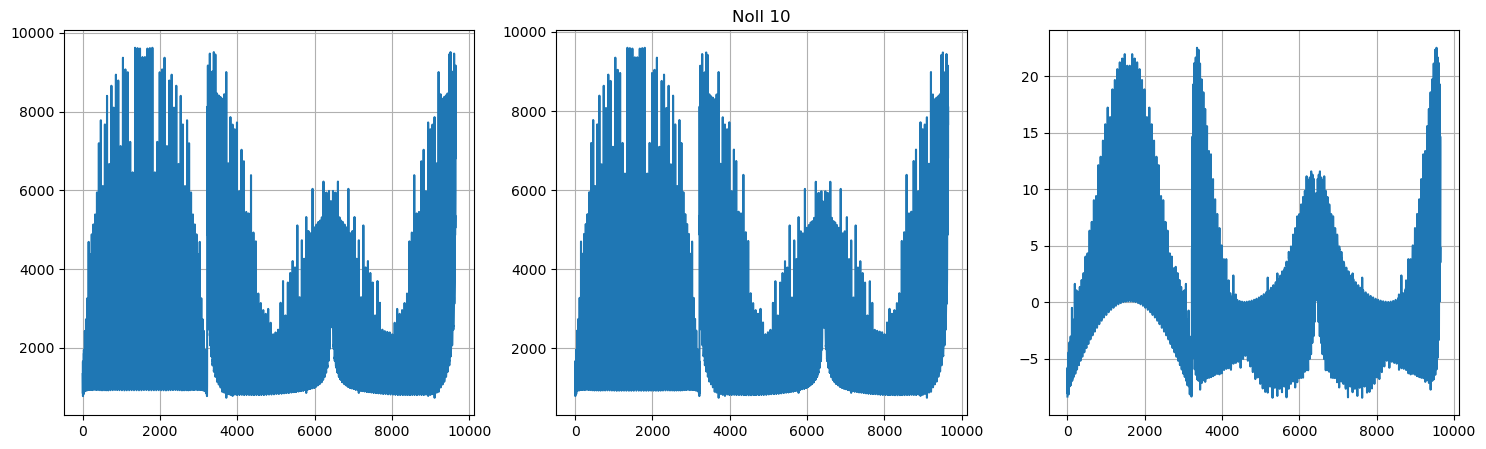

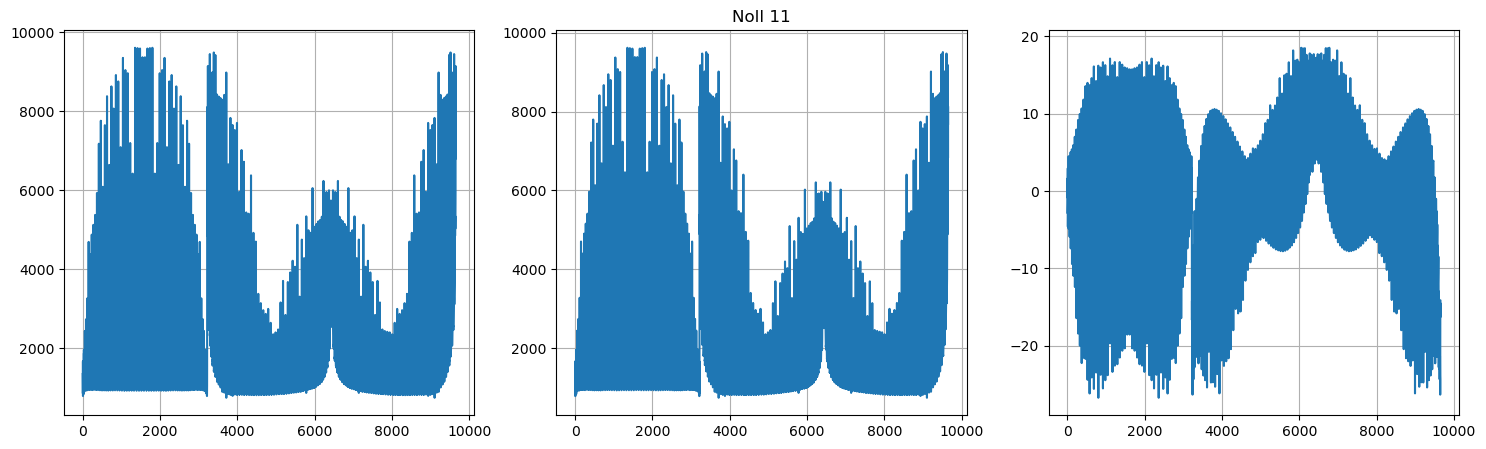

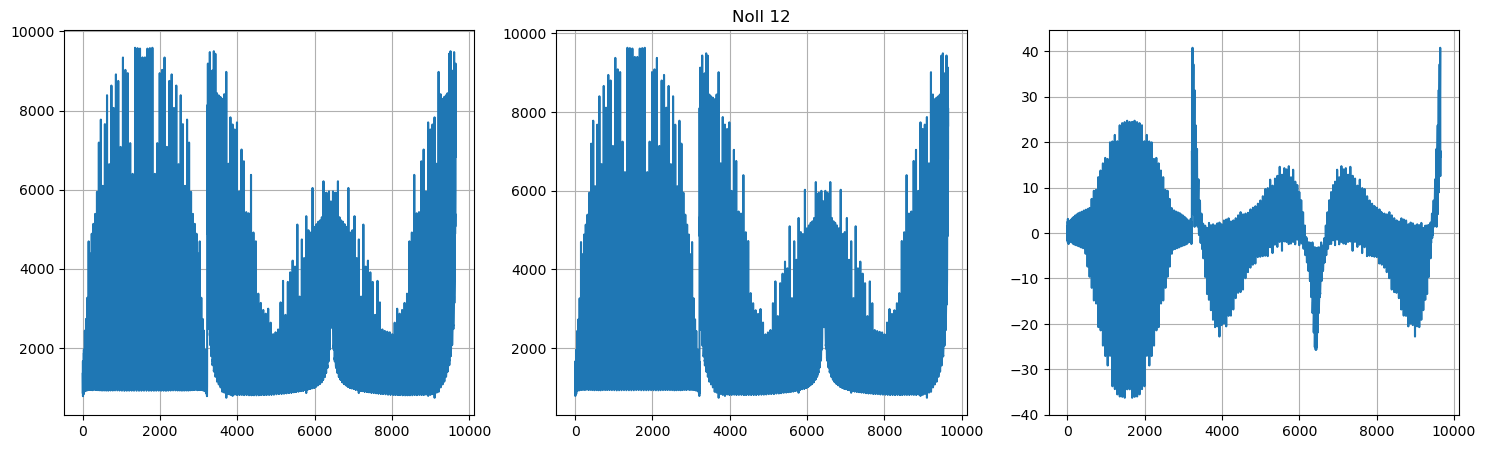

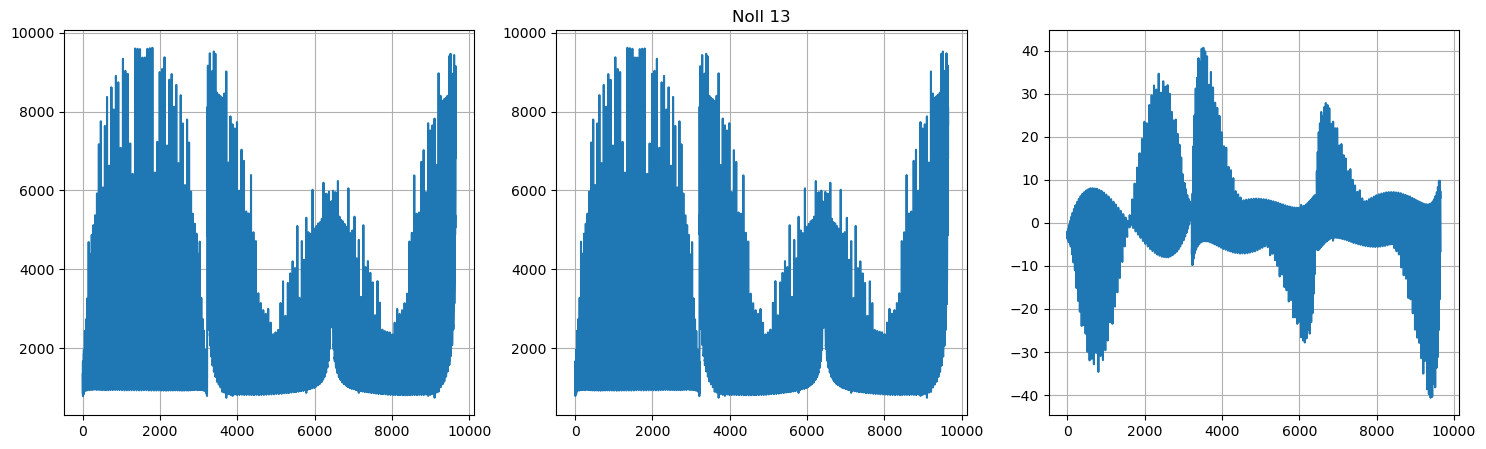

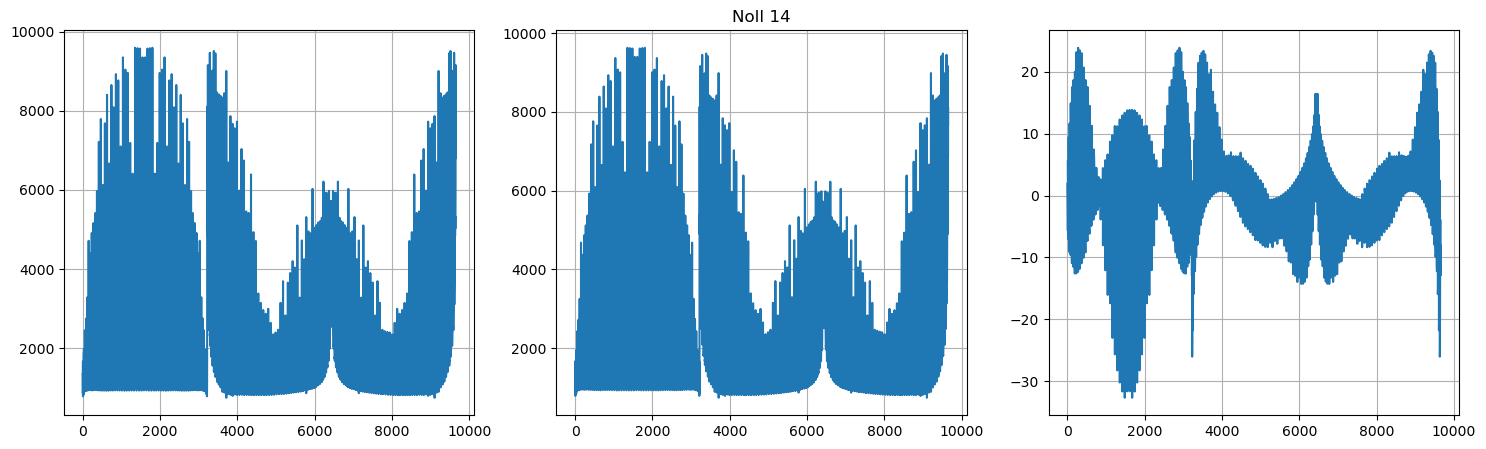

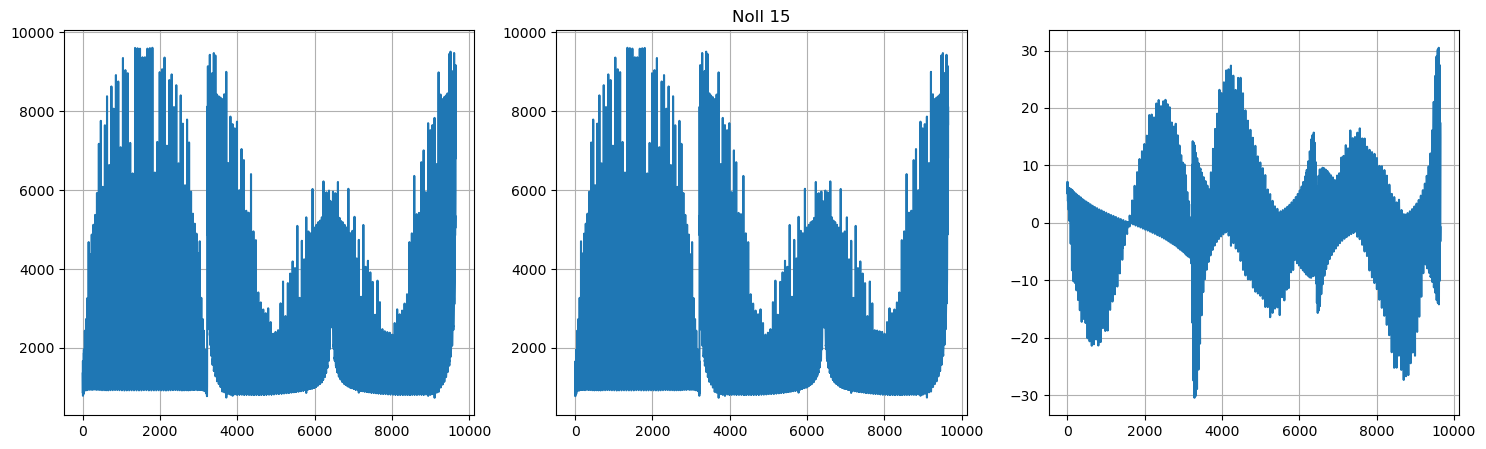

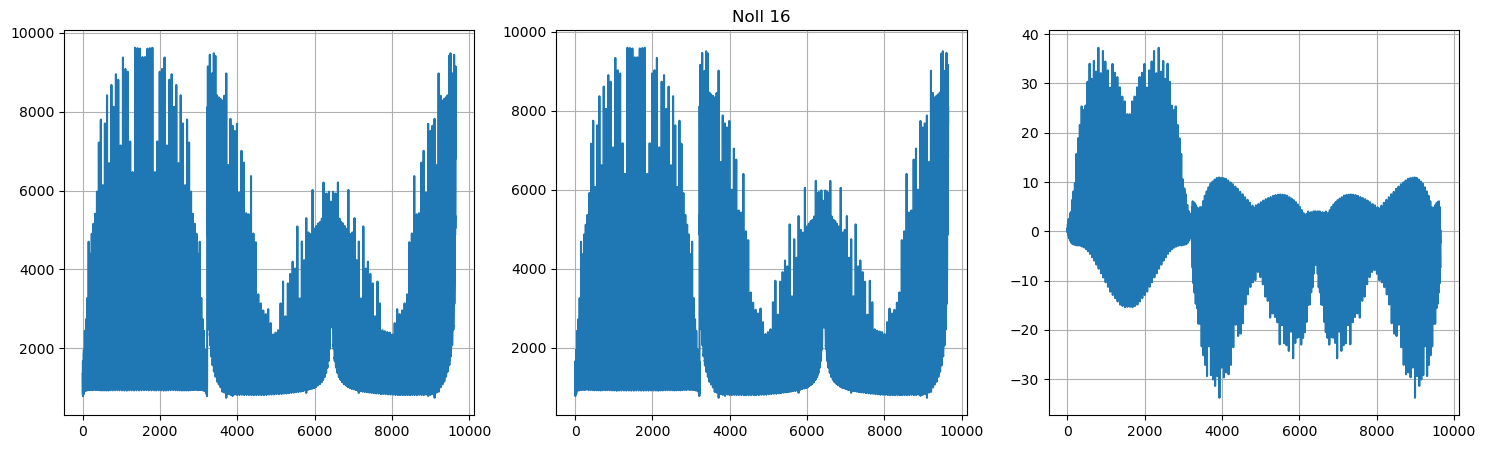

In [19]:
wfs.set_modulation_angle(0.0)
mod0_RecPP,mod0_IMpp = push_pull_calibrate(Nmodes=nRecModes, method=method, amp=0.002)

Modulating 0 [lambda/D] with 0 modulation steps
0.0


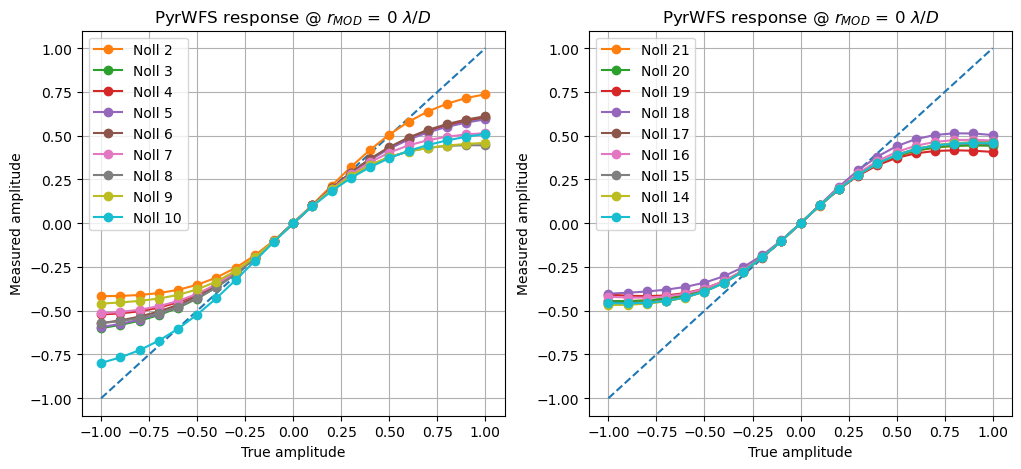

In [22]:
# Linearity check
Nmodes = 9
wfs.set_modulation_angle(0.0)
print(wfs.modulationAngleInLambdaOverD)
amp_vec = xp.linspace(-1,1,21,endpoint=True)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(amp_vec),xp.asnumpy(amp_vec),'--')
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(amp_vec),xp.asnumpy(amp_vec),'--')

intensities = xp.zeros((Nmodes,xp.shape(output_intensity)[0],xp.shape(output_intensity)[1]))
rev_intensities = xp.zeros((Nmodes,xp.shape(output_intensity)[0],xp.shape(output_intensity)[1]))

for j in range(Nmodes):

    zid = j + 2
    meas_amp = xp.zeros_like(amp_vec)

    rev_zid = nRecModes - j
    rev_meas_amp = xp.zeros_like(amp_vec)

    zero = create_field_from_zernike_coefficients(mask, 1, 0)
    slope_null = sc.compute_slopes(zero, lambdaOverD, nPhotons=None)

    for k,amp in enumerate(amp_vec):
        zern = create_field_from_zernike_coefficients(mask, zid, amp)
        slopes = sc.compute_slopes(zern, lambdaOverD, nPhotons=None)
        slopes -= slope_null
        output_intensity = ccd.last_frame
        zern_reconstructed = mod0_RecPP @ slopes
        meas_amp[k] = zern_reconstructed[zid-2]

        rev_zern = create_field_from_zernike_coefficients(mask, rev_zid, amp)
        slopes = sc.compute_slopes(rev_zern, lambdaOverD, nPhotons=None)
        slopes -= slope_null
        rev_output_intensity = ccd.last_frame
        zern_reconstructed = mod0_RecPP @ slopes
        rev_meas_amp[k] = zern_reconstructed[rev_zid-2]
    
    intensities[j,:,:] = output_intensity
    rev_intensities[j,:,:] = rev_output_intensity

    plt.subplot(1,2,1)
    plt.plot(xp.asnumpy(amp_vec), xp.asnumpy(meas_amp),'-o', label=f'Noll {zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 0 $\lambda/D$')
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(xp.asnumpy(amp_vec), xp.asnumpy(rev_meas_amp),'-o', label=f'Noll {rev_zid}')
    plt.legend(loc='best')
    plt.xlabel('True amplitude')
    plt.ylabel('Measured amplitude')
    plt.title(r'PyrWFS response @ $r_{MOD}$ = 0 $\lambda/D$')
    plt.grid(True)

IndexError: Index 9 is out of bounds for axis 0 with size 9

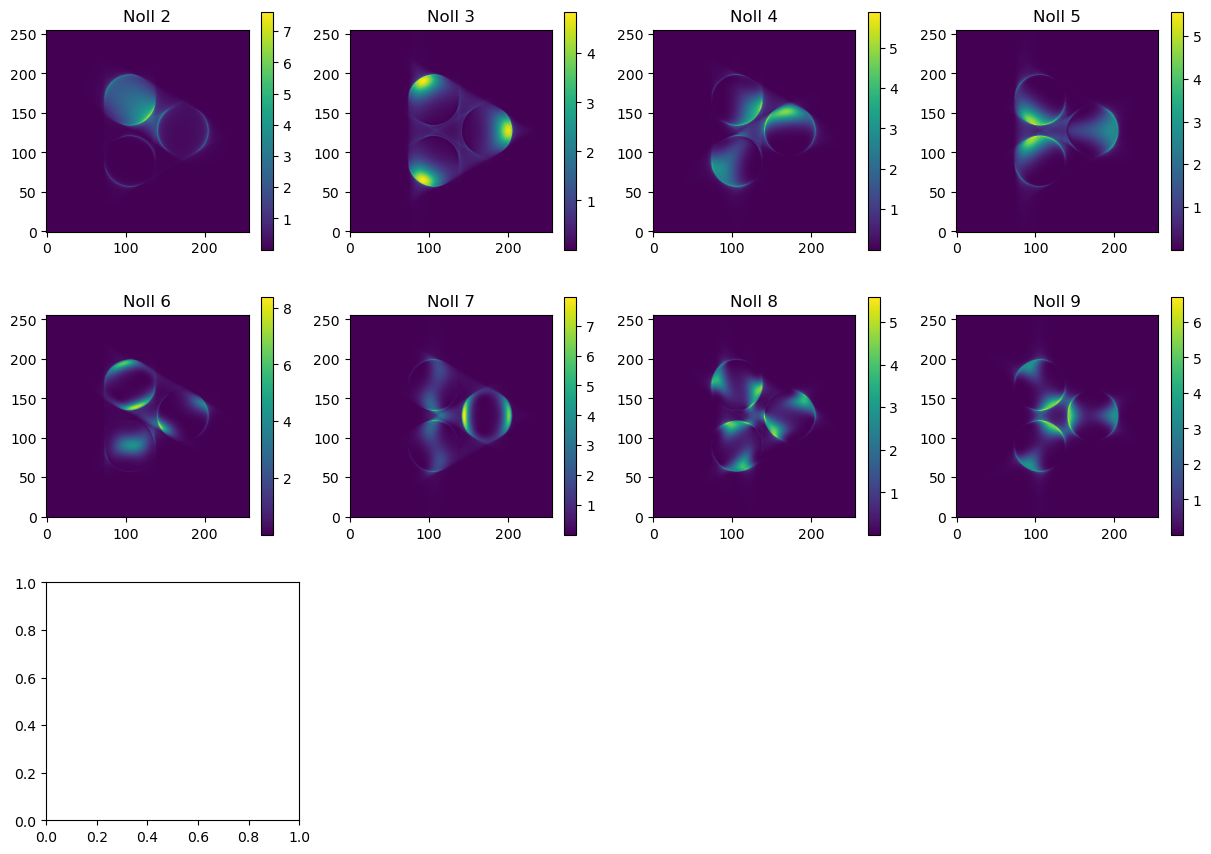

In [25]:
# Plot the intensity on the detector for the last iteration
n_rows = Nmodes//4+1
plt.figure(figsize=(15,3.5*n_rows))

for i in range(Nmodes):
    plt.subplot(n_rows,4,i+1)

    # plt.imshow((intensities[i,:,:]),origin='lower')
    plt.imshow(xp.asnumpy(toccd(intensities[i+1,:,:],ccd.detector_shape)),origin='lower')
    plt.colorbar()
    plt.title(f'Noll {i+2}')